# Mathematical Trading Strategies - Assignment 3

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
!pip install TA-Lib
import talib
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [ ]:
infy_df = yf.download('INFY', start="2003-05-23")

[*********************100%***********************]  1 of 1 completed


# Using only Indicator : Keltner Channel

## Calculate the channel

In [ ]:
def calculate_keltner_channel(dataframe, period=20, multiplier=2):
    ma = talib.SMA(dataframe['Close'], timeperiod=period)

    atr = talib.ATR(dataframe['High'], dataframe['Low'], dataframe['Close'], timeperiod=period)

    upper_band = ma + (multiplier * atr)
    middle_band = ma
    lower_band = ma - (multiplier * atr)

    return upper_band, middle_band, lower_band

## Generate Signals

In [ ]:
def generate_kc_signals(df, period=20):
    df['kc_signal'] = 0
    upper_kc, _, lower_kc = calculate_keltner_channel(df, period)
    for i in range(len(df)):
        if df['Close'][i] > upper_kc[i]:
            df['kc_signal'][i] = -1  # Sell signal
        elif df['Close'][i] < lower_kc[i]:
            df['kc_signal'][i] = 1  # Buy signal
        else:
            df['kc_signal'][i] = 0  # No signal


## Optimise parameters and trading strategy

In [ ]:
keltner_channel_periods = range(5, 51)

metrics = pd.DataFrame(
    {
        'keltner_channel_period': np.zeros(len(keltner_channel_periods)),
        'strategy_returns': np.zeros(len(keltner_channel_periods)),
        'cumulative_returns': np.zeros(len(keltner_channel_periods)),
        'max_drawdown': np.zeros(len(keltner_channel_periods)),
        'sharpe_ratio': np.zeros(len(keltner_channel_periods))
    }
)

progress_bar = tqdm(total=len(keltner_channel_periods),
                    desc='Optimising Parameters', unit='Iterations')

for i in range(len(keltner_channel_periods)):
            metrics['keltner_channel_period'][i] = keltner_channel_periods[i]

            generate_kc_signals(infy_df, keltner_channel_periods[i])

            strategy_returns = infy_df['kc_signal'] * infy_df['Close'].pct_change().shift(-1)
            metrics['strategy_returns'][i] = strategy_returns[-2]

            cumulative_returns = (1 + strategy_returns).cumprod()
            metrics['cumulative_returns'][i] = cumulative_returns[-2]

            max_drawdown = ((cumulative_returns / cumulative_returns.cummax()) - 1).min()
            metrics['max_drawdown'][i] = max_drawdown

            sharpe_ratio = np.mean(strategy_returns) / np.std(infy_df['Close'].pct_change())
            metrics['sharpe_ratio'][i] = sharpe_ratio

            progress_bar.update(1)

progress_bar.close()

Optimising Parameters: 100%|██████████| 46/46 [01:58<00:00,  2.58s/Iterations]


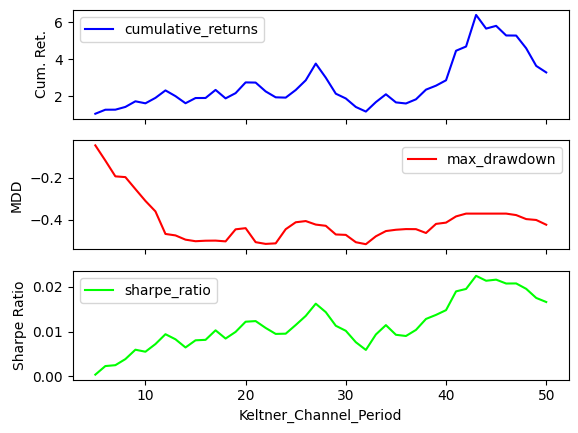

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.plot(metrics['keltner_channel_period'], metrics['cumulative_returns'], label='cumulative_returns', color='#0000ff')
ax1.set_ylabel('Cum. Ret.')
ax1.legend()

ax2.plot(metrics['keltner_channel_period'], metrics['max_drawdown'], label='max_drawdown', color='#ff0000')
ax2.set_ylabel('MDD')
ax2.legend()

ax3.plot(metrics['keltner_channel_period'], metrics['sharpe_ratio'], label='sharpe_ratio', color='#00ff00')
ax3.set_xlabel('Keltner_Channel_Period')
ax3.set_ylabel('Sharpe Ratio')
ax3.legend()

plt.show()

We can clearly note that when we keep period = 10, we get the maxiumum cumulative returns, Sharpe ratio and the minimum maximum drawdown (which is negative in the graph)

# Signal Generation from Chart Pattern: Head and Shoulders

## Generate trade signals

In [ ]:
def generate_hns_signals(df, shoulderperiod=5, headperiod=10):

    left_shoulder = talib.SMA(df['High'], timeperiod=shoulderperiod)
    head = talib.SMA(df['Low'], timeperiod=headperiod)
    right_shoulder = talib.SMA(df['High'], timeperiod=shoulderperiod)

    # Detect the head and shoulders pattern
    pattern = (left_shoulder < head) & (right_shoulder < head)

    df['hns_signal'] = 0

    for i in range(len(pattern)):
        if pattern[i] and i >= 2:  # Check if the pattern is present and has completed
            if df['Close'][i] > df['Close'][i-1] and df['Close'][i-1] < df['Close'][i-2]:
                df['hns_signal'][i] = 1  # Buy signal
            elif df['Close'][i] < df['Close'][i-1] and df['Close'][i-1] > df['Close'][i-2]:
                df['hns_signal'][i] = -1  # Sell signal
            else:
                df['hns_signal'][i] = 0  # No signal
        else:
            df['hns_signal'][i] = 0  # No signal

## Optimise parameters and metrics

In [ ]:
head_periods = range(8, 16)
shoulder_periods = range(3, 9)

metrics = np.zeros((3, len(shoulder_periods), len(head_periods)))

progress_bar = tqdm(total=(len(shoulder_periods)*len(head_periods)),
                    desc='Optimising Parameters', unit='Iterations')

for spi in range(len(shoulder_periods)):
    for hpj in range(len(head_periods)):
        generate_hns_signals(infy_df, shoulder_periods[spi], head_periods[hpj])

        strategy_returns = infy_df['hns_signal'] * infy_df['Close'].pct_change().shift(-1)

        cumulative_returns = (1 + strategy_returns).cumprod()
        metrics[0][spi][hpj] = cumulative_returns[-2]

        max_drawdown = ((cumulative_returns / cumulative_returns.cummax()) - 1).min()
        metrics[1][spi][hpj] = max_drawdown

        sharpe_ratio = np.mean(strategy_returns) / np.std(infy_df['Close'].pct_change())
        metrics[2][spi][hpj] = sharpe_ratio

        progress_bar.update(1)

progress_bar.close()

Optimising Parameters: 100%|██████████| 48/48 [02:01<00:00,  2.53s/Iterations]


In [ ]:
metrics[0][0][0]

0.4829117851549749

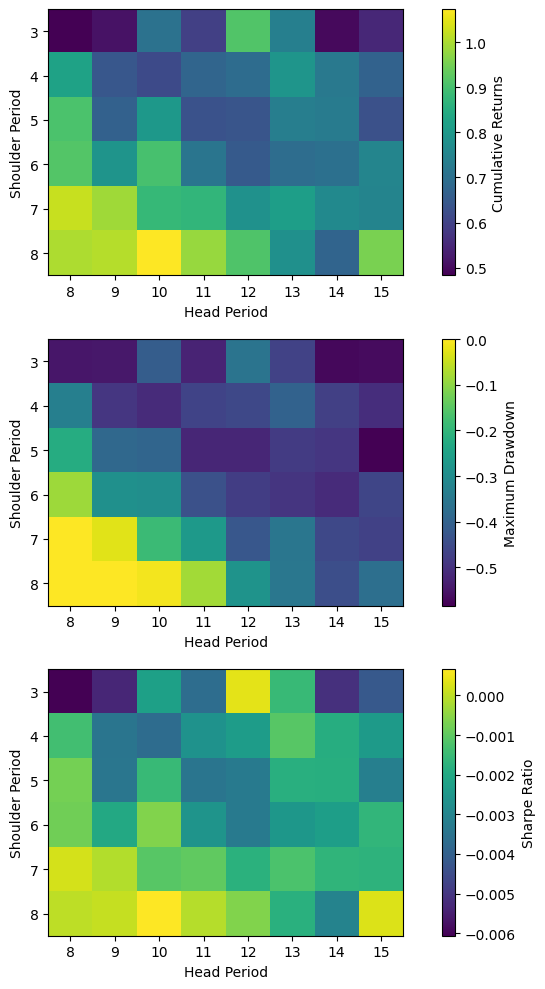

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

im1 = ax1.imshow(metrics[0])
ax1.set_ylabel('Shoulder Period')
ax1.set_xlabel('Head Period')
cbar1 = ax1.figure.colorbar(im1, ax=ax1)
cbar1.set_label('Cumulative Returns')
ax1.set_yticks(range(len(shoulder_periods)))
ax1.set_yticklabels(shoulder_periods)
ax1.set_xticks(range(len(head_periods)))
ax1.set_xticklabels(head_periods)

im2 = ax2.imshow(metrics[1])
ax2.set_ylabel('Shoulder Period')
ax2.set_xlabel('Head Period')
cbar2 = ax2.figure.colorbar(im2, ax=ax2)
cbar2.set_label('Maximum Drawdown')
ax2.set_yticks(range(len(shoulder_periods)))
ax2.set_yticklabels(shoulder_periods)
ax2.set_xticks(range(len(head_periods)))
ax2.set_xticklabels(head_periods)

im3 = ax3.imshow(metrics[2])
ax3.set_ylabel('Shoulder Period')
ax3.set_xlabel('Head Period')
cbar3 = ax3.figure.colorbar(im3, ax=ax3)
cbar3.set_label('Sharpe Ratio')
ax3.set_yticks(range(len(shoulder_periods)))
ax3.set_yticklabels(shoulder_periods)
ax3.set_xticks(range(len(head_periods)))
ax3.set_xticklabels(head_periods)

plt.tight_layout()
plt.show()


In [ ]:
x, y = np.unravel_index(np.argmax(metrics[0]), metrics[0].shape)
(shoulder_periods[x], head_periods[y])

(8, 10)

In [ ]:
head_periods[np.unravel_index(np.argmax(metrics[0]), metrics[0].shape)[1]]

10

In [ ]:
print(f'Cumulative Returns are maximum(={round(np.max(metrics[0]),4)}) for and around shoulder_period={shoulder_periods[(np.unravel_index(np.argmax(metrics[0]), metrics[0].shape))[0]]} and head_period={head_periods[(np.unravel_index(np.argmax(metrics[0]), metrics[0].shape))[1]]}')
print(f'Maximum Drawdowns are minimum(={round(np.min(metrics[1]),4)}) for and around shoulder_period={shoulder_periods[(np.unravel_index(np.argmin(metrics[1]), metrics[1].shape))[0]]} and head_period={head_periods[(np.unravel_index(np.argmin(metrics[1]), metrics[1].shape))[1]]}')
print(f'Sharpe Ratios are maximum(={round(np.max(metrics[2]),4)}) for and around shoulder_period={shoulder_periods[(np.unravel_index(np.argmax(metrics[2]), metrics[2].shape))[0]]} and head_period={head_periods[(np.unravel_index(np.argmax(metrics[2]), metrics[2].shape))[1]]}')

Cumulative Returns are maximum(=1.0735) for and around shoulder_period=8 and head_period=10
Maximum Drawdowns are minimum(=-0.5834) for and around shoulder_period=5 and head_period=15
Sharpe Ratios are maximum(=0.0007) for and around shoulder_period=8 and head_period=10


Considering the heatmaps and the data, we can take shoulder_period=8 and head_period=10 for our strategy

# Combined Signal Generation

In [ ]:
def generate_combined_signals(df : pd.DataFrame, kcp : int, hp : int, sp : int):
    upper_kc, _, lower_kc = calculate_keltner_channel(df, kcp)

    left_shoulder = talib.SMA(df['High'], timeperiod=sp)
    head = talib.SMA(df['Low'], timeperiod=hp)
    right_shoulder = talib.SMA(df['High'], timeperiod=sp)

    pattern = (left_shoulder < head) & (right_shoulder < head)

    df['combined_signal'] = 0


    for i in range(len(df)):
        if ((df['Close'][i] > upper_kc[i]) or (pattern[i] and i>=2)):
            df['combined_signal'][i] = -1  # Sell signal
        elif df['Close'][i] < lower_kc[i]:
            df['combined_signal'][i] = 1  # Buy signal
        else:
            df['combined_signal'][i] = 0  # No signal


In [ ]:
# Define parameter ranges for optimization
keltner_channel_period = range(10, 15, 2)
head_period = range(8, 15)
shoulder_period = range(3, 8)

In [ ]:
best_params = {
    'keltner_channel': 20,
    'head_and_shoulders': (5,10)
}
best_metrics = {
    'returns': -np.inf,
    'cumulative_returns': -np.inf,
    'max_drawdown': np.inf,
    'sharpe_ratio': -np.inf
}

In [ ]:
progress_bar = tqdm(total=len(keltner_channel_period) * len(head_period) * len(shoulder_period),
                    desc='Optimising Parameters', unit=' Iterations')

for kcp in keltner_channel_period:
    for hp in head_period:
        for sp in shoulder_period:

            generate_combined_signals(infy_df, kcp, hp, sp)

            strategy_returns = infy_df['combined_signal'] * infy_df['Close'].pct_change().shift(-1)

            cumulative_returns = (1 + strategy_returns).cumprod()

            max_drawdown = ((cumulative_returns / cumulative_returns.cummax()) - 1).min()

            sharpe_ratio = np.mean(strategy_returns) / np.std(infy_df['Close'].pct_change())

            if strategy_returns.iloc[-2] > best_metrics['returns']:
                best_metrics['returns'] = strategy_returns.iloc[-2]
                best_metrics['cumulative_returns'] = cumulative_returns.iloc[-2]
                best_metrics['max_drawdown'] = max_drawdown
                best_metrics['sharpe_ratio'] = sharpe_ratio
                best_params['keltner_channel'] = kcp
                best_params['head_and_shoulders'] = (sp, hp)

            progress_bar.update(1)

progress_bar.close()

Optimising Parameters: 100%|██████████| 105/105 [04:17<00:00,  2.46s/ Iterations]


In [ ]:
print(best_params)
print('---------------------------------------------------------')
print(best_metrics)

{'keltner_channel': 10, 'head_and_shoulders': (3, 8)}
---------------------------------------------------------
{'returns': 0.0, 'cumulative_returns': 0.8936658507429346, 'max_drawdown': -0.6337189179613973, 'sharpe_ratio': 0.0009814080329944516}


# Testing the strategy on Wipro

In [ ]:
wipro_df = yf.download('WIT', start='2003-05-23')

[*********************100%***********************]  1 of 1 completed


In [ ]:
generate_combined_signals(wipro_df, kcp= best_params['keltner_channel'], hp= best_params['head_and_shoulders'][1], sp= best_params['head_and_shoulders'][0])

strategy_returns = wipro_df['combined_signal'] * wipro_df['Close'].pct_change().shift(-1)

cumulative_returns = (1 + strategy_returns).cumprod()

max_drawdown = ((cumulative_returns / cumulative_returns.cummax()) - 1).min()

sharpe_ratio = np.mean(strategy_returns) / np.std(wipro_df['Close'].pct_change())

In [ ]:
print(f'Cumulative Returns = {cumulative_returns[-2]}')
print(f'Maximum Drawdown = {max_drawdown}')
print(f'Sharpe Ratio = {sharpe_ratio}')

Cumulative Returns = 0.8564942920409337
Maximum Drawdown = -0.5852768748828434
Sharpe Ratio = 0.0003772636276682439


In [ ]:
generate_kc_signals(wipro_df, 10)

strategy_returns = wipro_df['kc_signal'] * wipro_df['Close'].pct_change().shift(-1)

cumulative_returns = (1 + strategy_returns).cumprod()

max_drawdown = ((cumulative_returns / cumulative_returns.cummax()) - 1).min()

sharpe_ratio = np.mean(strategy_returns) / np.std(wipro_df['Close'].pct_change())

In [ ]:
print(f'Cumulative Returns = {cumulative_returns[-2]}')
print(f'Maximum Drawdown = {max_drawdown}')
print(f'Sharpe Ratio = {sharpe_ratio}')

Cumulative Returns = 1.9601354678204042
Maximum Drawdown = -0.3127291017632108
Sharpe Ratio = 0.0065436680476842635


In [ ]:
generate_hns_signals(wipro_df, 8, 10)

strategy_returns = wipro_df['hns_signal'] * wipro_df['Close'].pct_change().shift(-1)

cumulative_returns = (1 + strategy_returns).cumprod()

max_drawdown = ((cumulative_returns / cumulative_returns.cummax()) - 1).min()

sharpe_ratio = np.mean(strategy_returns) / np.std(wipro_df['Close'].pct_change())

In [ ]:
print(f'Cumulative Returns = {cumulative_returns[-2]}')
print(f'Maximum Drawdown = {max_drawdown}')
print(f'Sharpe Ratio = {sharpe_ratio}')

Cumulative Returns = 1.0095918746943087
Maximum Drawdown = -0.03094095922451523
Sharpe Ratio = 8.302076957888068e-05
